In [1]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import keras.backend as K
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
def plot(img1, img2):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[1].imshow(img2)
    ax[1].axis('off')
    f.suptitle('a')
    plt.show()

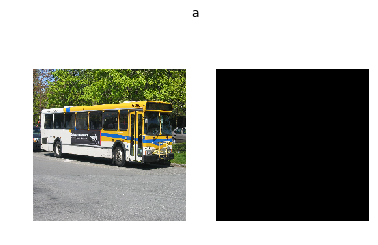

In [3]:
img = image.load_img('./data/bus_0.jpg', target_size = (224, 224))
baseline = np.zeros((224, 224, 3)).astype(np.uint8)
plot(img, baseline)

In [4]:
def preprocess(path):
    try:
        img = image.load_img(path, target_size = (224, 224))
        x = image.img_to_array(img)
    except:
        x = path
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [5]:
x = preprocess('./data/bus_0.jpg')
x_ = preprocess(baseline)

In [6]:
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
pred = model.predict(x)
pred_ix = np.argmax(pred)
print(pred_ix)
decode_predictions(pred)

654


[[('n03769881', 'minibus', 0.70898926),
  ('n04146614', 'school_bus', 0.129505),
  ('n03977966', 'police_van', 0.052966382),
  ('n04487081', 'trolleybus', 0.031650662),
  ('n04065272', 'recreational_vehicle', 0.015183358)]]

In [8]:
model_grad = K.gradients(model.output[:, pred_ix], model.input)
iterate = K.function([model.input], model_grad)

In [9]:
def normalize(img):
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    return img

In [10]:
batch = []
steps = 200
for i in range(steps):
    batch.append((x - x_) * i / steps + x_)
batch = np.concatenate(batch, axis = 0)
batch.shape

(200, 224, 224, 3)

In [11]:
model_grad = K.gradients(model.output[:, pred_ix], model.input)
iterate = K.function([model.input], model_grad)
igs = []
for i in range(0, steps, 5):
    igs.append(iterate([batch[i : i + 5]])[0])

In [12]:
igs_ = np.concatenate(igs, axis = 0)

In [13]:
igs_ = normalize(np.sum(np.mean(igs_, axis = 0) / steps * np.squeeze((x - x_)), axis = -1))

(array([4.0000e+00, 0.0000e+00, 3.7000e+01, 2.7900e+02, 5.3230e+03,
        4.3381e+04, 9.9000e+02, 1.3100e+02, 2.1000e+01, 1.0000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

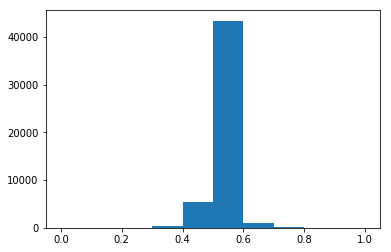

In [14]:
plt.hist(igs_.reshape(-1) / 255.0)

In [15]:
thres_ix = int(np.sort(igs_.reshape(-1)).shape[0] * 0.02)
thres = np.sort(normalize(igs_).reshape(-1))[-thres_ix]
thres

155

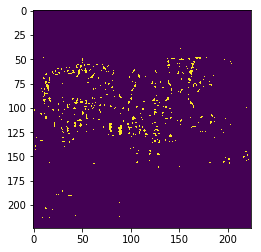

In [16]:
plt.imshow(normalize(igs_) > thres)

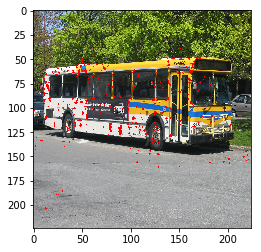

In [17]:
x, y = np.where((normalize(igs_) > thres) != 0)
c = image.img_to_array(img).astype(np.uint8)
c[x, y, :] = np.array([255, 0, 0])
plt.imshow(c)

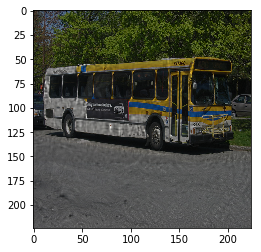

In [18]:
c = image.img_to_array(img)
plt.imshow((c * igs_.reshape(224, 224, 1) / 255).astype(np.uint8))

In [19]:
c.shape

(224, 224, 3)